# This file utilizes local simulations NOT ON QUANTUM COMPUTERS
- The intention is to use this file to more clearly visualize what is happening in this experiment, and to test if qiskit's features are properly setup on your device

### This heavily uses information and code from IBM's CHSH Inequality Tutorial
- More information can be found at https://learning.quantum.ibm.com/tutorial/chsh-inequality

In [20]:
# General
import numpy as np

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp

# Qiskit estimator to use on local computer (Not quantum computer)
from qiskit.primitives import StatevectorEstimator as LocalEstimator

# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

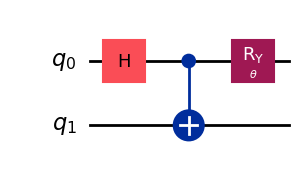

In [21]:
#Sets up parameter for rotations to be applied to Bob's basis:
theta = Parameter("$\\theta$")

#Initializes quantum cirucit with two quantum registers
chsh_circuit = QuantumCircuit(2)

#Applies a Hadamard gate to q0, the first step in creating an entanglment
chsh_circuit.h(0)

#Applies a CNOT gate to q1, finalizing entanglment.
chsh_circuit.cx(0, 1)

#Applies a rotation on q0 to rotate it's bases by theta with respect q1's bases.
chsh_circuit.ry(theta, 0)

#Draw the circit to see it in a more clear and visual way.
chsh_circuit.draw(output="mpl", idle_wires=False, style="iqp")

In [30]:
#Creates a list of 21 phases which sweep from 0 to 2pi.
number_of_phases = 21
phases = np.linspace(0, 2 * np.pi, number_of_phases)

# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]

In [31]:
#Defines the two observables. Recall that these should be +-1 if quantum mechanics can be described by local hidden variable theories.
# <CHSH1> = <AB> - <Ab> + <aB> + <ab> -> <ZZ> - <ZX> + <XZ> + <XX>
observable1 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])
# <CHSH2> = <AB> + <Ab> - <aB> + <ab> -> <ZZ> + <ZX> - <XZ> + <XX>
observable2 = SparsePauliOp.from_list([("ZZ", 1), ("ZX", 1), ("XZ", -1), ("XX", 1)])

#Applies the circuit created to the observables.
isa_observable1 = observable1.apply_layout(layout=chsh_circuit.layout)
isa_observable2 = observable2.apply_layout(layout=chsh_circuit.layout)

In [32]:
#Use local estimator for expectation values without quantum computers. Seed=None sets a randomly generated seed.
estimator = LocalEstimator(seed=None)
pub = (
    chsh_circuit,  # ISA circuit
    [[isa_observable1], [isa_observable2]],  # ISA Observables
    individual_phases,  # Parameter values
)

#Runs the estimator to obtain simulated results.
job_result = estimator.run(pubs=[pub]).result()

#Returns the expectation values for each observable.
chsh1_est = job_result[0].data.evs[0]
chsh2_est = job_result[0].data.evs[1]

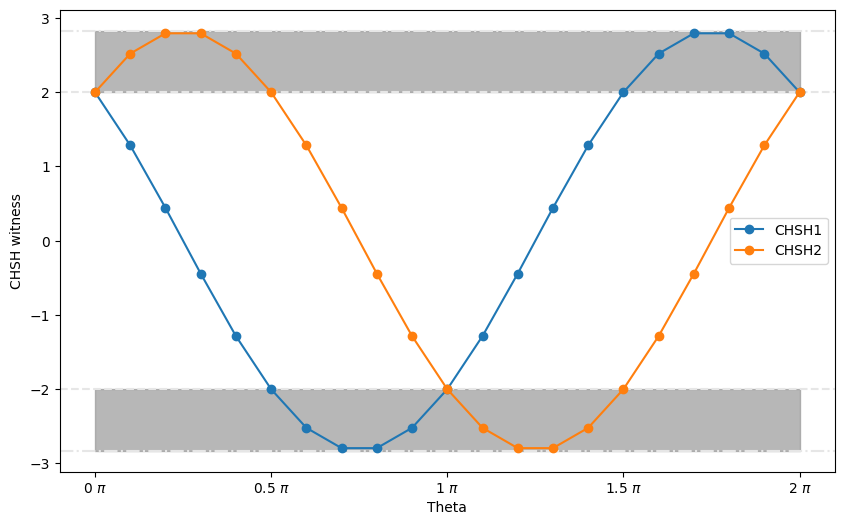

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

# results from local simulation
ax.plot(phases / np.pi, chsh1_est, "o-", label="CHSH1", zorder=3)
ax.plot(phases / np.pi, chsh2_est, "o-", label="CHSH2", zorder=3)

# classical bound +-2 (Will contain the function if quantum mechanics can be explained by hidden variables)
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

# quantum bound, +-2√2 (Functions will dip into this range if the results violate Bell's inequality)
ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.fill_between(phases / np.pi, 2, 2 * np.sqrt(2), color="0.6", alpha=0.7)
ax.fill_between(phases / np.pi, -2, -2 * np.sqrt(2), color="0.6", alpha=0.7)

# set x tick labels to the unit of pi
ax.xaxis.set_major_formatter(tck.FormatStrFormatter("%g $\\pi$"))
ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))

# set labels, and legend
plt.xlabel("Theta")
plt.ylabel("CHSH witness")
plt.legend()
plt.show()